<a href="https://colab.research.google.com/github/khayk5ay/Anomaly_Detection/blob/main/Anomaly_Detection_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The essence of an anomaly detection algorithm is to detect strange occurences whose probability of occurence is quite unlikely.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Generate random dataset for the algorithm analysis
def generate_dataset():
  X_train_list = []
  X_val_list = []
  y_val_list = []

  # Generate the training set containing values considered to be normal
  for i in range(50):
    X_train_list.append([random.uniform(65,75), random.uniform(60,70)])

  X_train = np.array(X_train_list)

  # Generate the validation set of some normal and other anomolous values
  for i in range(20):
    X_val_list.append([random.uniform(65,75), random.uniform(60,70)])
    y_val_list.append(0)
  for i in range(5):
    X_val_list.append([random.uniform(40,60), random.uniform(50,80)])
    y_val_list.append(1)
  for i in range(5):
    X_val_list.append([random.uniform(75,85), random.uniform(50,80)])
    y_val_list.append(1)

  X_val = np.array(X_val_list)
  y_val = np.array(y_val_list)

  return X_train, X_val, y_val

In [3]:
# Initialise Training dataset for training
X_train, X_val, y_val = generate_dataset()

X_train[:3]

array([[72.3983819 , 69.57106119],
       [68.14268734, 65.04656536],
       [74.8461818 , 60.26857317]])

(30.0, 100.0)

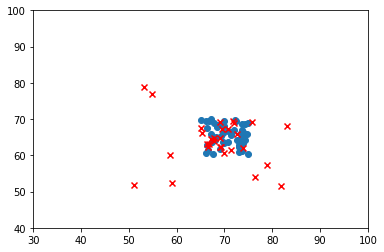

In [4]:
# Visualise the data
plt.scatter(X_train[:,0], X_train[:, 1], marker='o')
plt.scatter(X_val[:,0], X_val[:, 1], color='r', marker='x')
plt.ylim(40,100)
plt.xlim(30,100)

In [5]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

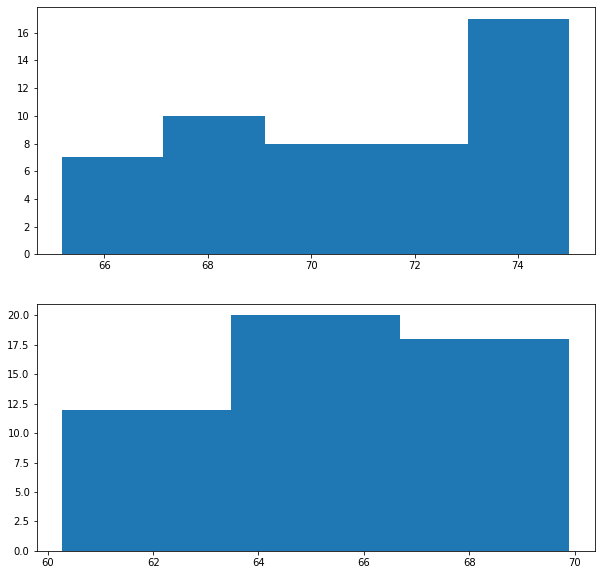

In [6]:
# Look at the distribution of each of the features in X_train

fig, ax = plt.subplots(2,1, figsize=(10,10))
 
ax[0].hist(X_train[:,0], bins=5) 
ax[1].hist(X_train[:,1], bins=3)
plt.show()

Even though the data does not necessarily have a normal / gaussian distribution, the algorithm still does well to detect any anomalies

In [7]:
# Get the values if Mean and Variance for the data set
def get_gaussian_distribution(X):
  """
  gets the gaussian distribution of the data

  parameters:
  X (numpy ndarray) : m * n dimensioned unlabeled data

  returns:
  mu () : 1 * n array showing the mean of the data
  var () : 1 * n array showing the variance of the data
  
  """
  m, n = X.shape
  # Compute the mean of each featrue in the data set
  mu = sum(X) / m
  # Compute the variance of each feature in the data set
  var = sum((X-mu)**2) / m
  
  return mu, var

In [8]:
mu, var = get_gaussian_distribution(X_train)

In [9]:
print(f"The mean is {mu}")
print(f"The variance is {var}")

The mean is [70.76938913 65.45086873]
The variance is [8.65136777 8.00272647]


In [10]:
(list(range(len(mu))))

[0, 1]

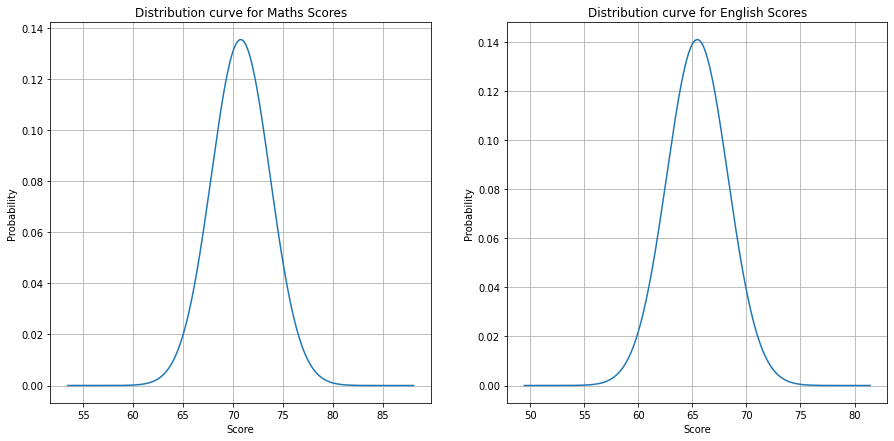

In [79]:
features = ["Maths", "English"]
fig,ax = plt.subplots(1,2, figsize=(15,7))

for i in range(len(mu)):
  x_axis = np.arange(mu[i] - 2 * var[i], mu[i] + 2 * var[i], 0.05)
  ax[i].plot(x_axis, norm.pdf(x_axis, mu[i], np.sqrt(var[i])))
  ax[i].grid()
  ax[i].set_xlabel("Score")
  ax[i].set_ylabel("Probability")
  ax[i].set_title(f"Distribution curve for {features[i]} Scores")

plt.show()

$$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

$$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

In [12]:
# Get probabilities of features when provided with the array of all observations when provided witht he values of the gaussian distribution 

def get_probabilities(X, mu, var):
  # Check that X is a 2D array
  if len(X.shape) != 2:
     X = X.reshape(1, len(X))
  # Initialise the array to hold the probabilities
  p_x_j = np.zeros(len(X))
  
  # Get probabiliities for each observation
  for j in range(len(X)):
    # Initialise the array that will hold the probabilities for each feature associated with the overall observation
    p_x_i = np.zeros(X[j].shape[0])
    for i in range(X[j].shape[0]):
      # Compute the probability of each individual feature
      denom = np.sqrt(2 * np.pi * var[i])
      exp_val = -((X[j][i]-mu[i]) ** 2 )/ (2 * var[i])
      p_x_i[i] = (1 / denom) * np.exp(exp_val)

    # Compute the overall probability of that observation as the product of all the feature probabilities
    p_x_j[j] = np.prod(p_x_i)

  return p_x_j

In [13]:
X_train_prob = get_probabilities(X_train, mu, var)
X_train_prob[:3]

array([0.005681  , 0.01270709, 0.00136702])

In [14]:
# Determine the threshold probability below which an observation will be considered abnormal
# The threshold will be considered using the F1 score
def select_threshold(y_val, p_val):

  best_F1 = 0
  best_epsilon = 0
  step_value = (p_val.max() - p_val.min()) / 1000
  # Consider a wide range of threshold values
  for epsilon in np.arange(p_val.min(), p_val.max(), step_value):
    
    predictions = p_val < epsilon
    # Compute the True Positive (tp), False Positive(fp), False Negative(fn)
    tp = sum(predictions[y_val == 1])
    fp = sum(predictions[y_val == 0])
    fn = sum(y_val[predictions == 0])

    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    
    #Compute the f1 score for each value of epsilon
    F1 = (2 * precision_score * recall_score) / (precision_score + recall_score)

    if F1 > best_F1:
      best_F1 = F1
      best_epsilon = epsilon

  return best_F1, best_epsilon    


In [16]:
F1_score, epsilon = select_threshold(y_val, get_probabilities(X_val, mu, var))
print("F1 Score ", F1_score)
print("Best Epsilon ", epsilon)

F1 Score  1.0
Best Epsilon  0.0019439430537320978


<ipython-input-14-df9f30cc4f1e>:17: RuntimeWarning: invalid value encountered in long_scalars
  precision_score = tp / (tp + fp)


In [44]:
epsilon = get_probabilities(mu - (2*stdev), mu, var)

In [45]:
# Predict anomalous occurences based on already trained parameters
def predict(X_test, epsilon, mu, var):

  y_prob = get_probabilities(X_test, mu, var)

  y_pred = (y_prob < epsilon) + 0

  return y_pred

In [46]:
y_pred = predict(X_val, epsilon, mu, var)

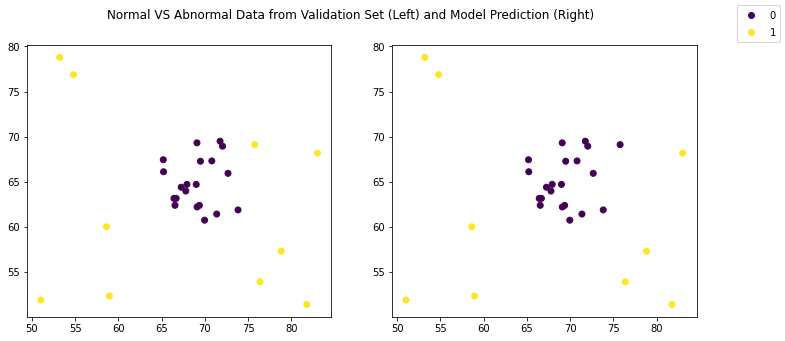

In [47]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

scatter1= ax[0].scatter(X_val[:,0], X_val[:,1], c=y_val)
scatter2= ax[1].scatter(X_val[:,0], X_val[:,1], c=y_pred)
ax[1].set_label(y_pred)

fig.legend(*scatter1.legend_elements());
fig.suptitle("Normal VS Abnormal Data from Validation Set (Left) and Model Prediction (Right)");

In [39]:
stdev = np.sqrt(var)
mu - (3*stdev)
get_probabilities(mu - (3*stdev), mu, var)

array([2.360524e-06])

Now that our algorithm seems to be doing well on randomised data, let us see how it performs on real data. I will be using data gotten from the electricity consumption of a building over the course of 3 years. We will see how it performs with that data.

In [48]:
energy_data = pd.read_csv("/content/Tetuan City power consumption.csv")
energy_data_values = energy_data[["Zone 1 Power Consumption", "Zone 2  Power Consumption"]].values


In [49]:
len(energy_data_values)

52416

In [50]:
l = [energy_data_values[num].tolist() for num in np.arange(0, 20000, 144)]
l_arr = np.array(l)


Because the values are so large, we will scale the data. We could easily use the Min Max Scaler from Sklearn, however, in keeping with our trend of creating helper functions, we will create a function to scale the data for us


In [51]:
def minmax_scaler(array):
  
  mini = []
  maxi = []
  for i in np.arange(len(array[0])):
    mini.append(array[:,i].min())
    maxi.append(array[:,i].max())

  minis = np.array(mini)
  maxis = np.array(maxi)

  return (array - minis) / (maxis - minis)
        

In [52]:
l_arr_norm = minmax_scaler(l_arr)
l_arr_norm[:3]

array([[1.        , 0.35866872],
       [0.19998087, 0.67276579],
       [0.19535266, 0.75994863]])

In [53]:
edv_mean_norm, edv_variance_norm = get_gaussian_distribution(l_arr_norm)

print(edv_variance_norm)
edv_mean_norm

[0.01495862 0.03623796]


array([0.50147411, 0.63135936])

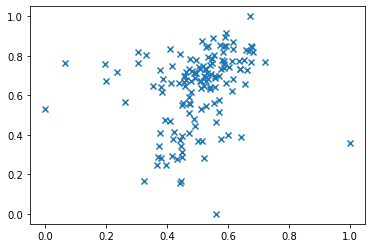

In [54]:
plt.scatter(l_arr_norm[:,0], l_arr_norm[:, 1], marker='x')
# plt.ylim(0,8)
# plt.xlim(10,40)

As the values are quite many, 

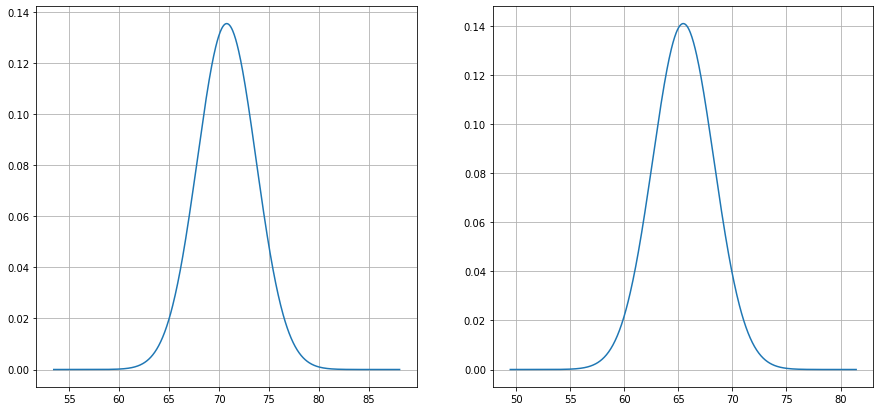

In [55]:
fig,ax = plt.subplots(1,2, figsize=(15,7))

for i in range(len(mu)):
  x_axis = np.arange(mu[i] - 2 * var[i], mu[i] + 2 * var[i], 0.05)
  ax[i].plot(x_axis, norm.pdf(x_axis, mu[i], np.sqrt(var[i])))
  ax[i].grid()

plt.show()

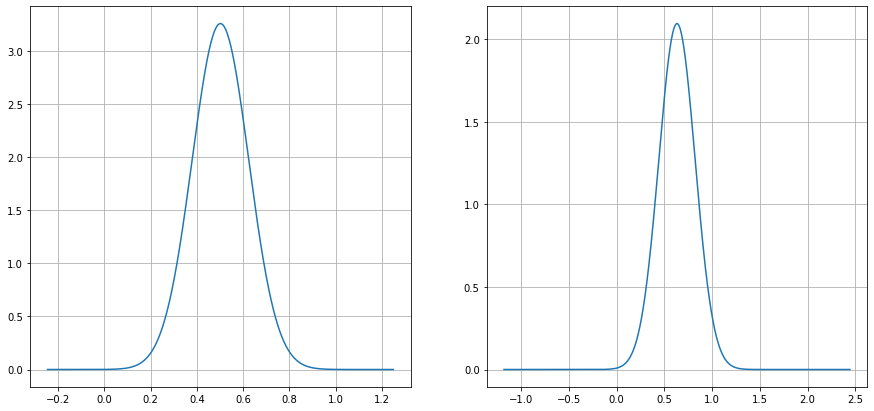

In [56]:
fig,ax = plt.subplots(1,2, figsize=(15,7))

for i in range(len(edv_mean_norm)):
  x_axis = np.arange(edv_mean_norm[i] - 50 * edv_variance_norm[i], edv_mean_norm[i] + 50 * edv_variance_norm[i], 0.0001)
  ax[i].plot(x_axis, norm.pdf(x_axis, edv_mean_norm[i], np.sqrt(edv_variance_norm[i])))
  ax[i].grid()

plt.show()

In [57]:
edv_prob_norm = get_probabilities(l_arr_norm, edv_mean_norm, edv_variance_norm)
edv_prob_norm.max()

6.809976917662744

Since we do not have already labeled values, we will utilize the Empirical rule of normal distrbutions. 

It states that 68.2% of the observations will be found +/- one standard deviation from the mean, 95.4% will be found at mean +/- two standard deviations and 99.7% will fall within three standard deviations of the mean

In [65]:
epsilon = get_probabilities((edv_mean_norm - (2 * np.sqrt(edv_variance_norm)), edv_mean_norm, edv_variance_norm)

In [66]:
edv_y_norm = predict(l_arr_norm, epsilon, edv_mean_norm, edv_variance_norm)

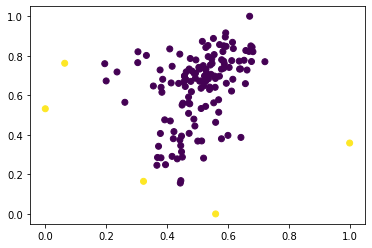

In [67]:
plt.scatter(l_arr_norm[:,0], l_arr_norm[:, 1], c=edv_y_norm)